## 1. Reproduce Wiggins' K-means result

In [462]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.facecolor'] = 'white'

infile = 'w05-data.tbl'

"""
 THESE ARE ALL PROVIDED FUNCTIONS FROM THE INSTRUCTIONS !
"""

def read_data(infile):
    '''
    read_data(infile)
    Read Lestrade's input file, w05-data.tbl, or a file in that format.
    Return:
       ctype[0..N-1] : cell types 0..Q-1 for each cell i
       data[i,g]     : array of count data; rows = cells i; cols = genes g
       N             : number of cells (rows of the data file)
       G             : number of genes (cols of the data file, after the first)
       Q             : number of cell types
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

def initialize_at_true():
    '''
    initialize_at_true():
    Returns the true mu centroids, and the true proportions;
    don't say I never gave you anything.
       mu[q,g]  : array of means for mixture q, gene g
       qp[q]    : mixture coefficient for mixture q
    '''
    qp = np.array([ 0.1, 0.2, 0.4, 0.2, 0.1 ])
    mu = np.array([[   30., 2000. ],
                   [ 2000., 2000. ],
                   [  300.,  300. ],
                   [   30.,   30. ],
                   [ 2000,    30. ]])
    return mu, qp


def visualize_data(data, mu, C,title):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    if ((title == 'Clusters Ploted on the Raw Counts') | (title == 'Clusters Ploted on the Raw Data (Neg-Binomial Mixture Model)')):
        ax.set_xlabel('caraway (counts)')
        ax.set_ylabel('kiwi (counts)')
    elif title == 'Clusters Ploted on the Log-Transformed Counts':
        ax.set_xlabel('caraway log(counts)')
        ax.set_ylabel('kiwi log(counts)')
    plt.title(title)
    plt.show()


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# reading in the w05-features.tbl 
ctype, data, N, G, Q = read_data(infile)

In [386]:
import scipy

class hard_KMeans():

    def __init__ (self, seed, k, N, G,features):
        """
        Initializing class variables
        """
        self.seed = seed
        self.k = k # number of clusters
        self.N = N # number of cells
        self.G = G # number of features/genes
        self.features = features
        self.features_df = pd.DataFrame(features)
        self.tsd = 0 # initializing total - squared distance
        self.centroid = np.zeros((self.k,self.G)) # initializing a mu matrix

  

    def centroid_initialization(self):

        """
        This function first finds the max and min for each feature in the feautre set,
        and then randomly selects k numbers for each feature. It returns a k x G 2-dimensional numpy array.
        For example, a feature set with 2 genes and 5 clusters (k) will return a 5 by 2 numpy array.
        """

        np.random.seed(self.seed)
        max_min_for_each_dim = [(max(self.features[dim]),min(self.features[dim])) for dim in self.features_df]
        start_centroid = np.zeros((self.G,self.k))
        for dim,max_min_tuple in enumerate(max_min_for_each_dim):
            start_centroid[dim] = np.random.uniform(low = max_min_tuple[1], high = max_min_tuple[0],size = self.k)
        self.centroid = start_centroid.reshape(self.k,self.G)
    

        return self.centroid


    def assign_clusters(self):

        """
        The functions takes in centroid and features matrix and computes the euclidean distance matrix
        between each feature vector and each centroid. Each cell is then assigned to its nearest centroid based
        on the distances computed in the distance matrix.
        """
        
        distance_matrix = scipy.spatial.distance_matrix(self.features,self.centroid) # Note: Sean said scipy is allowed
        self.features_df['cluster'] = [np.argmin(cell) for cell in distance_matrix]

        return self.features_df

    def total_squared_distance(self,new_centroids):

        """
        Given the features with clusters already assigned to them, this function calculates the total squared
        distance of every cell to its assigned centroid. There is one for loop that loops through all the clusters, 
        and computations over G and N are vectorized.
        """
        
        temp_tsd = 0

        for k in range(0,self.k):
            temp_df = self.features_df.query("cluster == @k")
            temp_tsd = temp_tsd + np.sum((temp_df.iloc[:,0:G].to_numpy() - new_centroids[k-1]) ** 2)

        return temp_tsd
    
    def update_centroid(self):

        """
        This function calculates new centroids based on features with given cluster assignments.
        There is one for loop that loops through all the clusters, and computations over G and N are vectorized.
        """

        new_centroid = np.zeros((self.k,self.G))
     
        for k in range(0,self.k):
            temp_df = self.features_df.query("cluster == @k")

            if temp_df.shape[0] != 0:
                new_centroid[k-1] = (temp_df.iloc[:,0:G].sum(axis = 0) / temp_df.shape[0]).to_numpy()
            else:
                continue
                    
        temp_tsd = np.round(self.total_squared_distance(new_centroid),decimals = 1)
        
        status = 'go'
        if temp_tsd < self.tsd:
            self.tsd = temp_tsd
            self.centroid = new_centroid
            status = 'go'
        elif temp_tsd >= self.tsd :
            status = 'converged'

        return status

    def train(self):


        """
        This function "trains" the hard k-means model by first initalizing the centroids
        and then iterating through the following steps until convergence:

        1. Assignment step: Assign each data point X_i to its closest centroid μ_k.

        2. Update step: Calculate new centroids μ_k.

        The function is ran on 10 different seeds
        """
        train_status = 'go'
        initial_centroids = self.centroid_initialization()
        training_cycle = 0
        while train_status != 'converged':
 
            self.assign_clusters()
            if training_cycle == 0:
                self.tsd = np.round(self.total_squared_distance(self.centroid),decimals = 1)
            train_status = self.update_centroid()
            training_cycle += 1 
        self.assign_clusters()
        print('Total Squared Distance {}'.format(self.tsd))
        
        
        return self.centroid, self.features_df['cluster'].to_numpy(), self.tsd



    

### Running hard k-means on 10 random seeds and find the best run:

Total Squared Distance 399622102.9
Total Squared Distance 399622102.9
Total Squared Distance 399622102.9
Total Squared Distance 399622102.9
Total Squared Distance 399622102.9
Total Squared Distance 399622102.9
Total Squared Distance 399622102.9
Total Squared Distance 399989915.8
Total Squared Distance 399622102.9
Total Squared Distance 425733582.3


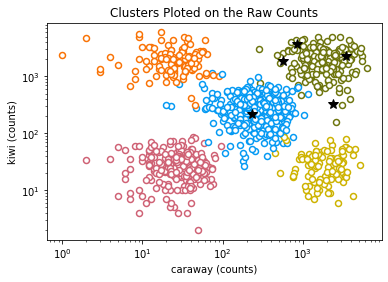

In [460]:
tot_sqdist_list = []
centroids_list = []
clusters_list = []
for seed in np.random.randint(0,40,size = 10):
    hard_kmeans = hard_KMeans(seed = seed,k = 5, N = N, G = G, features = data)
    centroids, clusters, tot_sqdist = hard_kmeans.train()
    tot_sqdist_list.append(tot_sqdist)
    centroids_list.append(centroids)
    clusters_list.append(clusters)
    best_run = np.argmin(tot_sqdist_list)
    centroids = centroids_list[best_run]

visualize_data(data, centroids, ctype, title = 'Clusters Ploted on the Raw Counts')

### The above plot of the five clusters obtained from my algorithm is identical to Wiggins' K-means plot. Running my K-means algorithm with 10 different seeds, we see that the best total squared distance is excatly 399622102.9 and all total squared distance are within 99622102.9 to 469469409.6. Thus, I replicated Wiggn's results pretty well.

###  A good statistics for choosing the "best" solution for K-means is total squared distance (a.k.a. total within clusters sum of squares). We now use total squared distance to pick an optimal cluster.

Total Squared Distance 2218920643.8
Total Squared Distance 1157398431.0
Total Squared Distance 656868077.8
Total Squared Distance 502363214.2
Total Squared Distance 425733582.3
Total Squared Distance 344181997.7
Total Squared Distance 292171171.3
Total Squared Distance 240519882.1
Total Squared Distance 209039216.8
Total Squared Distance 200470532.6


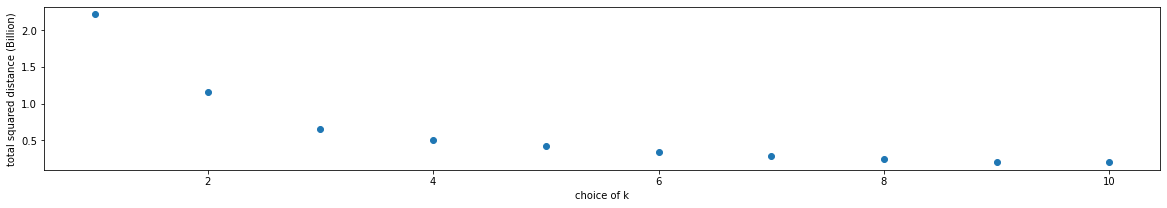

In [461]:
clust = [1,2,3,4,5,6,7,8,9,10]
tot_sqdist_list = []
for num_clust in clust:
    hard_kmeans = hard_KMeans(seed = seed,k = num_clust, N = N, G = G, features = data)
    centroids, clusters, tot_sqdist = hard_kmeans.train()
    tot_sqdist_list.append(tot_sqdist)

plt.figure(figsize=(20,3))    
plt.scatter(clust, (np.array(tot_sqdist_list) / 1000000000), marker = 'o')
plt.xlabel('choice of k')
plt.ylabel('total squared distance (Billion)')
plt.show()
    


### According to the graph above, the total squared distance does not decrease much once you have 8 clusters. One possible reason why K-means clustering produced the bad results it did is that the genes counts are extremely right skewed. We need to log transform the raw counts to make the data more normalized. We will plug in the log-transformed gene counts into our model in PART 3.


Text(0.5, 0, 'log(counts)')

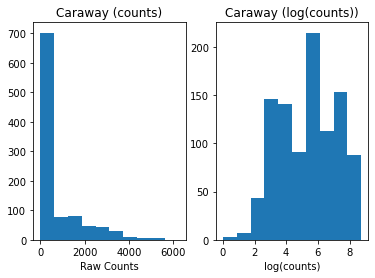

In [399]:
plt.subplot(1, 2, 1)
plt.hist(data[:,0])
plt.title('Caraway (counts)')
plt.xlabel('Raw Counts')
plt.subplot(1, 2, 2)
plt.hist(np.log(data[:,0]))
plt.title('Caraway (log(counts))')
plt.xlabel('log(counts)')

## 2. Mixture negative binomial fitting

In [466]:
from scipy import special


class mixture_neg_binom():

    def __init__ (self, seed, k, N, G,features):
        """
        Initializing class variables
        """
        self.seed = seed # random seed
        self.k = k # number of clusters
        self.N = N # number of cells
        self.G = G # number of features/genes
        self.features = features
        self.features_df = pd.DataFrame(features)
        self.mu = np.zeros((self.k,self.G)) # initializing a centroid matrix
        self.phi = 0.3
        self.pi = np.zeros((self.k,1))
        self.posterior = np.zeros((self.N,self.k))
        self.neg_log_likelihood = 100000000
     


    def mu_initialization(self):

        """
        This function first finds the max and min for each feature in the feautre set,
        and then randomly selects k numbers for each feature. It returns a k x G 2-dimensional numpy array.
        For example, a feature set with 2 genes and 5 clusters (k) will return a 5 by 2 numpy array.
        Pi (prior) os also initialized through a random direichlet process.
        """

        np.random.seed(self.seed)
        max_min_for_each_dim = [(max(self.features[dim]),min(self.features[dim])) for dim in self.features_df]
        start_mu = np.zeros((self.G,self.k))
        for dim,max_min_tuple in enumerate(max_min_for_each_dim):
            start_mu[dim] = np.random.uniform(low = max_min_tuple[1], high = max_min_tuple[0],size = self.k)
        self.mu = start_mu.reshape(self.k,self.G)
        self.pi = np.random.dirichlet(np.ones(5),size=1).ravel()
        

        return self.mu, self.pi


    def e_step(self):
        
        """
        Calculate posterior probability. Assign each data point X_i to the centorid with the highets posterior probability.
        """
        
        p = np.zeros((self.k,self.G))
        n = 1 / self.phi
        y = self.features
        for k in range(0,self.k):
            p[k] = (1 / (1+self.mu[k] * self.phi))

        posterior_numerator =  np.zeros((self.N,self.k))
        for i in range(0,self.N): # where self.N is 1000
            for k in range(0,self.k): # where self.k is 5
                posterior_numerator[i,k] = (np.sum(scipy.stats.nbinom.logpmf(y[i,:],n,p[k])) +  np.log(self.pi[k]))

        posterior_denominator = special.logsumexp(posterior_numerator,axis=1)
        

        for i in range(0,self.N):
            for k in range(0,self.k):
                self.posterior[i,k] = posterior_numerator[i,k] - posterior_denominator[i]

        self.features_df['cluster'] = [np.argmax(cell) for cell in self.posterior]
        

        return self.posterior, posterior_numerator

    

    def update_mu(self,posterior_numerator):

        """
        Calculate new centroids μ_k and new pi based on the calculated posterior probability.
        """

        new_mu = np.zeros((self.k,self.G))
        new_pi = np.zeros((self.k,1))
     
        for k in range(0,self.k):
            for g in range(0,self.G):
                new_mu[k,g] = np.exp(special.logsumexp(np.log(self.features[:,g]) + self.posterior[:,k]) - special.logsumexp(self.posterior[:,k]))
                new_pi[k] = np.exp(special.logsumexp(self.posterior[:,k])) / self.N

        neg_log_likelihood = np.round(-np.sum(special.logsumexp(posterior_numerator,axis = 1)),decimals=1)

   
        status = 'go'
        if neg_log_likelihood < self.neg_log_likelihood:
            self.mu = new_mu
            self.pi = new_pi
            self.neg_log_likelihood = neg_log_likelihood
        elif neg_log_likelihood >= self.neg_log_likelihood:
            status = 'converged'
        
        
        return status
        


    def train(self):

        """
        This function "trains" the soft k-means model by first initalizing the centroids
        and then iterating through the following steps until convergence:

        1. Assignment step: Calculate posterior probability. Assign each data point X_i to the centorid with the highets posterior probability.

        2. Update step: Calculate new centroids μ_k and new pi based on the calculated posterior probability.
        """
        train_status = 'go'
        initial_mu = self.mu_initialization()
        training_cycle = 0
        while train_status != 'converged':
    
            posterior, posterior_numerator = self.e_step()
            train_status = self.update_mu(posterior_numerator)
            training_cycle += 1 
        print('Training Complete {} Cycles'.format(training_cycle))

        
        return self.mu, self.features_df['cluster'].to_numpy(), self.neg_log_likelihood




    




    

### Running mixture negative-binomial on 10 random seeds and find the best run:

Training Complete 11 Cycles
Training Complete 8 Cycles
Training Complete 18 Cycles
Training Complete 11 Cycles
Training Complete 16 Cycles
Training Complete 8 Cycles
Training Complete 20 Cycles
Training Complete 13 Cycles
Training Complete 10 Cycles
Training Complete 11 Cycles


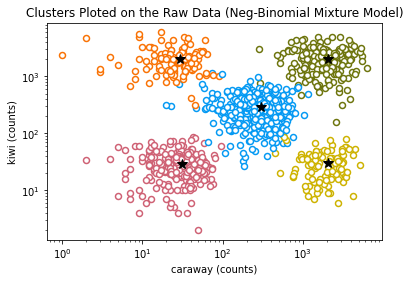

In [467]:
neg_log_likelihood_list = []
centroids_list = []
clusters_list = []
# run algorithm with 10 random seeds
for seed in np.random.randint(0,40,size = 10):
    mixture_negbinom = mixture_neg_binom(seed = seed,k = 5, N = N, G = G, features = data)
    centroids, clusters, neg_log_likelihood = mixture_negbinom.train()
    neg_log_likelihood_list.append(neg_log_likelihood)
    centroids_list.append(centroids)
    clusters_list.append(clusters)
# get index of the best run and get centroids and cluster assignment from the best run
best_run = np.argmin(tot_sqdist_list)
centroids = centroids_list[best_run]
clusters = clusters_list[best_run]

visualize_data(data, centroids, ctype, title = 'Clusters Ploted on the Raw Data (Neg-Binomial Mixture Model)')

### An appropriate statisitcs for choosing the best fit is to find the minimum -logP(X|$\theta$), which is the equivalent of finding the maximum P(X|$\theta$). Displayed below are the relative proportion of each cell type in the 1000 cells. 

In [468]:
data_df = pd.DataFrame(data,columns=['Caraway','Kiwi'])
data_df['cell_type'] = ctype
data_df['cluster'] = clusters

In [469]:
print('Proportion of each actual cell type in the 1000 cells:')
print(data_df['cell_type'].value_counts() / 1000)
print('Proportion of each cluster assignment per 1000 cell')
print(data_df['cluster'].value_counts() / 1000)

Proportion of each actual cell type in the 1000 cells:
2    0.383
3    0.211
1    0.190
0    0.114
4    0.102
Name: cell_type, dtype: float64
Proportion of each cluster assignment per 1000 cell
2    0.381
1    0.211
3    0.190
0    0.119
4    0.099
Name: cluster, dtype: float64


### We observe that the proportion of actual cell type per 1000 cells and the proportion of the cluster assignments per 1000 cells is very similar. We can see the correspondance between cluster and true cell types are as follows:
##### cell type 2 -> cluster 3 | cell type 3 -> cluster 1 | cell type 1 -> cluster 2 | cell type 0 -> cluster 4 | cell type 4 -> cluster 0


### The estimated mean expression levels of Caraway and Kiwi in the five cell types are displayed below. Because a cell type could be mapped to multiple clusters,we need a new column called mapped_cell that matches each cell type to the cluster based on the most similar proporiton out of 1000 

In [470]:
def map_cell_type(x):
    """
    Because a cell type could be mapped to multiple clusters,
    we need a new column called mapped_cell that matches each cell type
    to the cluster with the most similar proporiton out of 1000
    """
    
    if x == 3:
        y = 2
    elif x == 1:
        y = 3
    elif x == 2:
        y = 1
    elif x == 4:
        y = 0
    elif x == 0:
        y = 4
    return y
# applying the map_cell_type function 
data_df['mapped_cell'] = data_df['cluster'].apply(lambda x: map_cell_type(x))

# getting Caraway mu estimate
data_df['Caraway_Estimate'] = data_df['mapped_cell'].apply(lambda x: centroids[x][0])
# getting Kiwi mu estimate 
data_df['Kiwi_Estimate'] = data_df['mapped_cell'].apply(lambda x: centroids[x][1])

print(data_df.groupby('mapped_cell')['Caraway_Estimate'].unique().reset_index())
print(data_df.groupby('mapped_cell')['Kiwi_Estimate'].unique().reset_index())

   mapped_cell      Caraway_Estimate
0            0  [29.633255018675815]
1            1  [31.271254042274144]
2            2   [301.1353884183878]
3            3    [2084.05433670652]
4            4  [2065.2622495773694]
   mapped_cell         Kiwi_Estimate
0            0  [2061.8356614419226]
1            1  [29.178753683692605]
2            2  [294.98395687514056]
3            3  [2017.1705969793406]
4            4   [30.48980332605033]


## 3. Find a simple fix for K-means
### In part 1, I explained how a log transformation is necessary because data is skewed. Plugging the log-transformed gene counts into our model, we see that hard K-Means is now able to assign the correct cluster to each cell.

Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3
Total Squared Distance 711.3


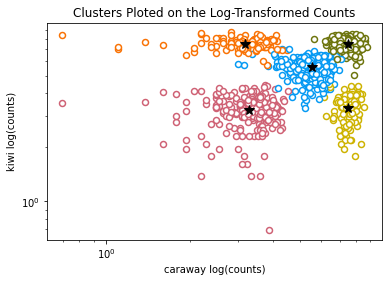

In [442]:
tot_sqdist_list = []
centroids_list = []
clusters_list = []
for seed in np.random.randint(0,40,size = 10):
    hard_kmeans = hard_KMeans(seed = seed,k = 5, N = N, G = G, features = np.log(data))
    centroids, clusters, tot_sqdist = hard_kmeans.train()
    tot_sqdist_list.append(tot_sqdist)
    centroids_list.append(centroids)
    clusters_list.append(clusters)
    best_run = np.argmin(tot_sqdist_list)
    centroids = centroids_list[best_run]

visualize_data(np.log(data), centroids, ctype, title = 'Clusters Ploted on the Log-Transformed Counts')